In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder_path = '/content/drive/MyDrive/Data/flowers'

## Load Data

In [3]:
data = []
label = []

SIZE = 128 #Crop the image to 128x128

for folder in os.listdir(folder_path):
    for file in os.listdir(os.path.join(folder_path, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_path, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

## Preprocess Data

In [4]:
#Convert Data to numeric value
data_arr = np.array(data)
label_arr = np.array(label)

In [5]:
#Label encoding and normalizing data
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y,5)
X = data_arr/255

In [6]:
#Train, Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

##Build a Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop


In [8]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation = "softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

##Data Augmentation to prevent Overfitting

In [9]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [10]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
batch_size=32
epochs=64
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/64
108/108 [==============================] - 33s 203ms/step - loss: 1.4968 - accuracy: 0.3102 - val_loss: 1.3436 - val_accuracy: 0.4294
Epoch 2/64
108/108 [==============================] - 20s 188ms/step - loss: 1.3335 - accuracy: 0.4205 - val_loss: 1.2267 - val_accuracy: 0.4942
Epoch 3/64
108/108 [==============================] - 20s 189ms/step - loss: 1.2544 - accuracy: 0.4738 - val_loss: 1.1465 - val_accuracy: 0.5139
Epoch 4/64
108/108 [==============================] - 20s 189ms/step - loss: 1.2087 - accuracy: 0.5039 - val_loss: 1.1395 - val_accuracy: 0.5162
Epoch 5/64
108/108 [==============================] - 20s 189ms/step - loss: 1.1684 - accuracy: 0.5210 - val_loss: 1.0796 - val_accuracy: 0.5544
Epoch 6/64
108/108 [==============================] - 20s 188ms/step - loss: 1.1218 - accuracy: 0.5476 - val_loss: 1.0843 - val_accuracy: 0.5602
Epoch 7/64
108/108 [==============================] - 21s 190ms/step - loss: 1.0967 - accuracy: 0.5633 - val_loss: 1.0395 - val_ac

##Recognize Flower

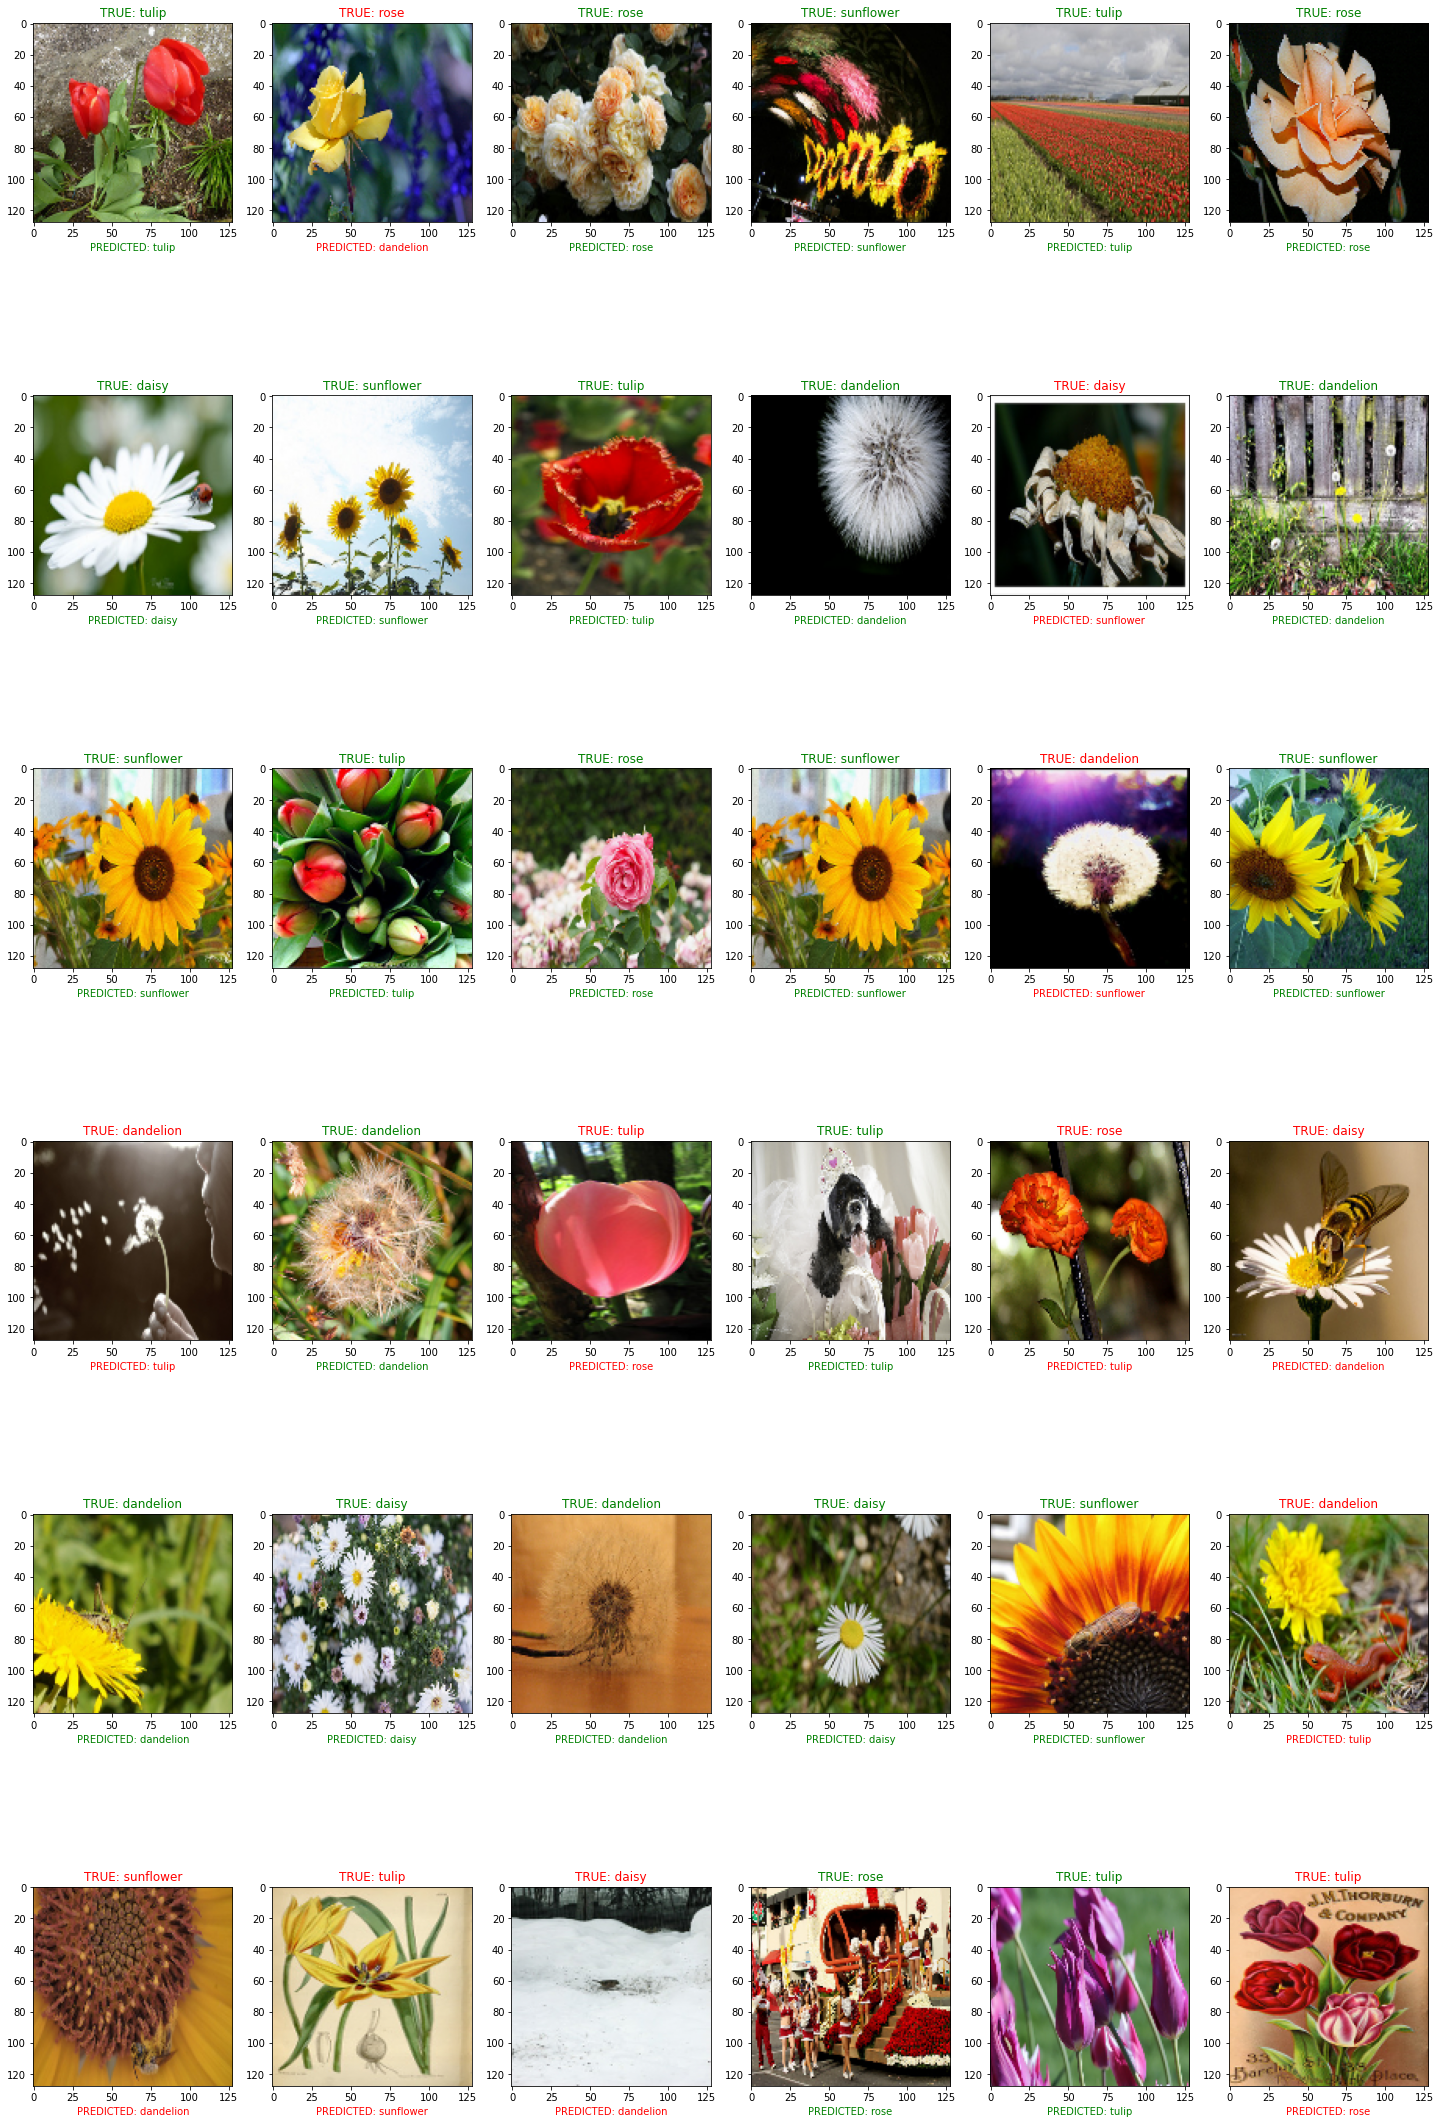

In [11]:
import matplotlib.pyplot as plt
categories = np.sort(os.listdir(folder_path))
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
        else:
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')

##Evaluating the Model Performance

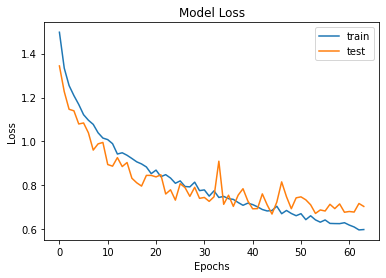

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

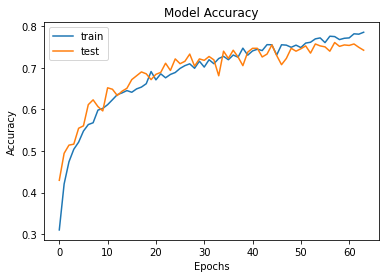

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()